In [ ]:
# take two weeks, 1 with worms, 1 without
# check if there is some nocturnal rhythm (worms are more active at night)
# run model for each picture to count worms
# output images with contours and make sure it is counting the worms correctly
# compare the two weeks
# take in sensor data like temperature, humidity, soil humidity, etc
# check if there is a correlation between the sensor data and the number of worms
# run the above for multiple weeks

In [268]:
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import roboflow
import pandas as pd
import supervision as sv
from inference import get_model
from PIL.ImageFile import ImageFile
import cv2
import seaborn as sns

In [4]:
model = get_model("wigglebin/2")

In [47]:
def analyze_image(image):
    results = model.infer(image)[0]
    return results

def draw_boxes(results, image_path, output_image_path):
    image = Image.open(image_path)
    image_np = np.array(image)  # Convert PIL image to NumPy array
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR

    # Convert the inference results to Supervisely format
    detections = sv.Detections.from_inference(results)

    # Create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()  # Set the color for bounding boxes
    label_annotator = sv.LabelAnnotator()  # Set the color for labels

    labels = [
        f"{model.class_names[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    # Annotate the image with our inference results
    annotated_image_rgb = bounding_box_annotator.annotate(scene=image_bgr, detections=detections)
    annotated_image_bgr = label_annotator.annotate(scene=annotated_image_rgb, detections=detections, labels=labels)

        # Convert the annotated image back to RGB format
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    annotated_image_pil = Image.fromarray(annotated_image_rgb)  # Convert NumPy array back to PIL image

    # Save the annotated image using PIL
    annotated_image_pil.save(output_image_path)

In [189]:
import numpy as np

# Define the folders containing the images
image_folders = [
    'downloads/daily/2024-08-26', 'downloads/daily/2024-08-27', 'downloads/daily/2024-08-28', 'downloads/daily/2024-08-29', 'downloads/daily/2024-08-30', 'downloads/daily/2024-08-31', 'downloads/daily/2024-09-01',  # week 35
    'downloads/daily/2024-09-02', 'downloads/daily/2024-09-03', 'downloads/daily/2024-09-04', 'downloads/daily/2024-09-05', 'downloads/daily/2024-09-06', 'downloads/daily/2024-09-07', 'downloads/daily/2024-09-08',  # week 36
    'downloads/daily/2024-09-09', 'downloads/daily/2024-09-10', 'downloads/daily/2024-09-11', 'downloads/daily/2024-09-12', 'downloads/daily/2024-09-13', 'downloads/daily/2024-09-14', 'downloads/daily/2024-09-15',  # week 37
    'downloads/daily/2024-09-16', 'downloads/daily/2024-09-17', 'downloads/daily/2024-09-18', 'downloads/daily/2024-09-19', 'downloads/daily/2024-09-20', 'downloads/daily/2024-09-21', 'downloads/daily/2024-09-22',  # week 38
    'downloads/daily/2024-09-23', 'downloads/daily/2024-09-23', 'downloads/daily/2024-09-25', 'downloads/daily/2024-09-26', 'downloads/daily/2024-09-27', 'downloads/daily/2024-09-28', 'downloads/daily/2024-09-29',  # week 39
    'downloads/daily/2024-09-30', 'downloads/daily/2024-10-01', 'downloads/daily/2024-10-02', 'downloads/daily/2024-10-03', 'downloads/daily/2024-10-04', 'downloads/daily/2024-10-05', 'downloads/daily/2024-10-06',  # week 40
    'downloads/daily/2024-10-07', 'downloads/daily/2024-10-08', 'downloads/daily/2024-10-09', 'downloads/daily/2024-10-10', 'downloads/daily/2024-10-11', 'downloads/daily/2024-10-12', 'downloads/daily/2024-10-13',  # week 41
    'downloads/daily/2024-10-14', 'downloads/daily/2024-10-15', 'downloads/daily/2024-10-16', 'downloads/daily/2024-10-17', 'downloads/daily/2024-10-18', 'downloads/daily/2024-10-19', 'downloads/daily/2024-10-10',  # week 42
]

all_results = []

# Loop over each folder
for folder in image_folders:
    # Loop over each image in the folder
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        
        # Open the image
        with Image.open(image_path) as img:
            # Analyze the image
            results = analyze_image(img)
            num_items_detected = len(results.predictions)

            # Append the image name and number of worms detected to the list
            all_results.append((image_name, image_path, results))


In [112]:
# show bounding boxes on the image
for (image_name, image_path, results) in all_results:
    draw_boxes(results, image_path, f"predictions/output/{image_name}")

In [203]:
data = []

# Loop over each image and its detection results
for (image_name, image_path, results) in all_results:
    worms_detected = [pred for pred in results.predictions if pred.class_name == 'worm']
    num_worms = len(worms_detected)
    
    # Extract date and time from image_name
    date_str = image_name.split('.')[0]
    date_time = pd.to_datetime(date_str, format='%Y-%m-%d-%H-%M')
    
    # Extract week number
    week_number = date_time.isocalendar().week
    
    data.append((image_name, num_worms, date_time, week_number))

# Create a DataFrame from the data
worms_detected_count = pd.DataFrame(data, columns=['image_name', 'num_worms', 'date_time', 'week_number'])

worms_detected_count = worms_detected_count.sort_values(by='date_time')
worms_detected_count

,image_name,num_worms,date_time,week_number
70,2024-08-26-00-00.jpg,0,2024-08-26 00:00:00,35
43,2024-08-26-00-10.jpg,0,2024-08-26 00:10:00,35
95,2024-08-26-00-20.jpg,0,2024-08-26 00:20:00,35
87,2024-08-26-00-30.jpg,0,2024-08-26 00:30:00,35
130,2024-08-26-00-40.jpg,0,2024-08-26 00:40:00,35
...,...,...,...,...
7701,2024-10-19-23-10.jpg,0,2024-10-19 23:10:00,42
7681,2024-10-19-23-20.jpg,0,2024-10-19 23:20:00,42
7654,2024-10-19-23-30.jpg,0,2024-10-19 23:30:00,42
7649,2024-10-19-23-40.jpg,0,2024-10-19 23:40:00,42


In [191]:
worms_detected_count.to_csv('./csv/worms_detected_count.csv', index=False)

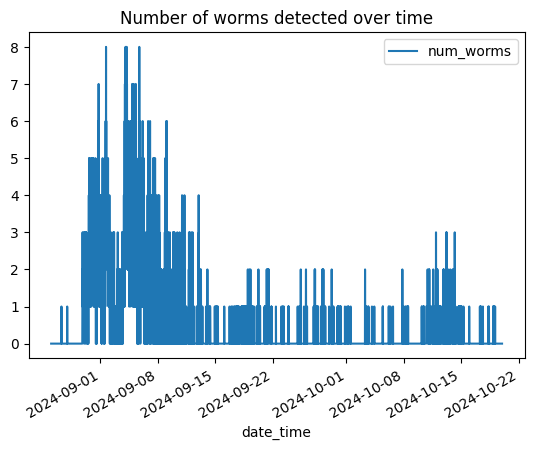

In [204]:
import matplotlib.pyplot as plt

worms_detected_count.plot(x='date_time', y='num_worms', kind='line', title='Number of worms detected over time')
plt.show()

## Nocturnal rhythm

Check if there is some nocturnal rhythm (worms are more active at night)

In [118]:
# TODO: Check if it is moisture related
# TODO: Check if it is light related

In [205]:
worms_per_hour = worms_detected_count.resample('h', on='date_time').agg({
    'num_worms': 'sum'
})

# Group by hour of the day and sum the number of worms detected
worms_per_hour['hour'] = worms_per_hour.index.hour
total_count_per_hour = worms_per_hour.groupby('hour')['num_worms'].sum().reset_index()

total_count_per_hour.head()

,hour,num_worms
0,0,184
1,1,231
2,2,240
3,3,179
4,4,190


<Axes: title={'center': 'Number of worms detected per hour'}, xlabel='date_time'>

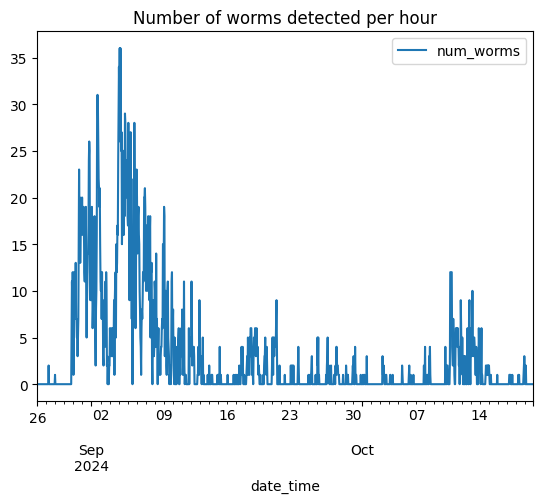

In [206]:
worms_per_hour.plot(y='num_worms', kind='line', title='Number of worms detected per hour')

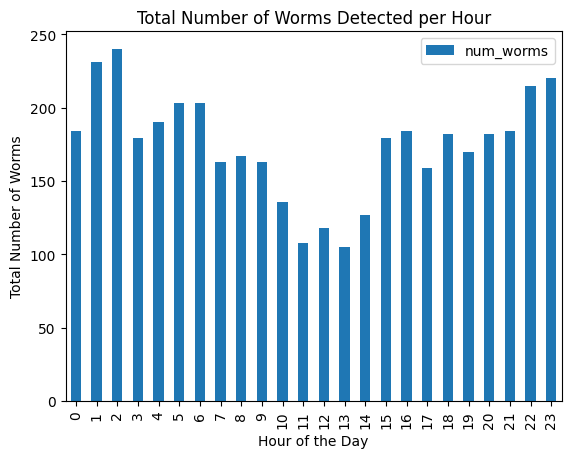

In [207]:
total_count_per_hour.plot(x='hour', y='num_worms', kind='bar', title='Total Number of Worms Detected per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Number of Worms')
plt.show()

## BME 680 sensor data correlation

Check if there is correlation between number of worms and BME sensor data

In [273]:
bme680 = pd.read_csv('./csv/sensors/bme680.csv')
bme680['time'] = pd.to_datetime(bme680['time'])
bme680

,time,temperature,humidity,pressure,altitude
0,2024-04-26 21:23:20.575159,21.346797,51.301884,1004.731889,-65.218030
1,2024-04-26 21:24:42.906707,21.357539,51.271890,1004.722466,-65.138788
2,2024-04-26 21:25:42.916602,21.271602,51.135652,1004.734881,-65.243186
3,2024-04-26 21:26:42.931706,21.177266,51.186387,1004.767363,-65.516309
4,2024-04-26 21:27:42.947395,21.104219,51.183424,1004.789164,-65.699614
...,...,...,...,...,...
35935,2024-11-17 08:00:35.321367,10.278633,71.644334,1010.013515,-109.534999
35936,2024-11-17 09:00:35.316728,10.140742,67.565376,1010.198153,-111.080858
35937,2024-11-17 10:00:35.310046,10.383125,66.225411,1010.697705,-115.262153
35938,2024-11-17 11:00:35.311304,12.122383,56.856142,1010.830981,-116.377404


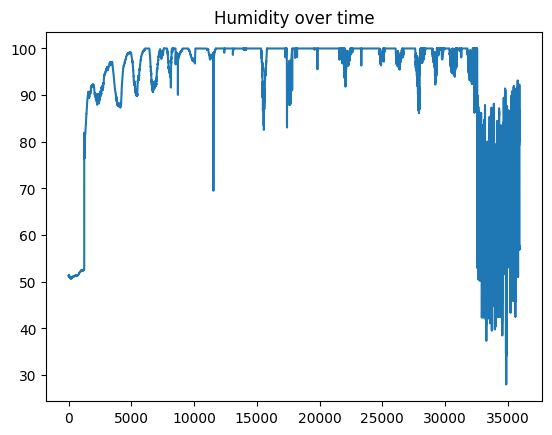

In [244]:
bme680['humidity'].plot(title='Humidity over time')
plt.show()

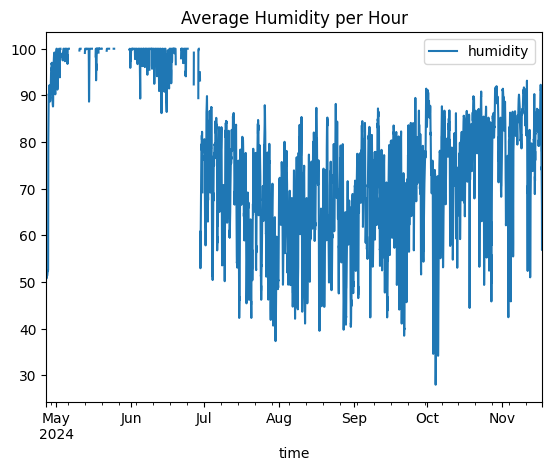

In [280]:
bme680_per_hour = bme680.resample('h', on='time').agg({
    'humidity': 'mean',
    'temperature': 'mean',
    'pressure': 'mean',
})

bme680_per_hour.plot(y='humidity', kind='line', title='Average Humidity per Hour')
plt.show()

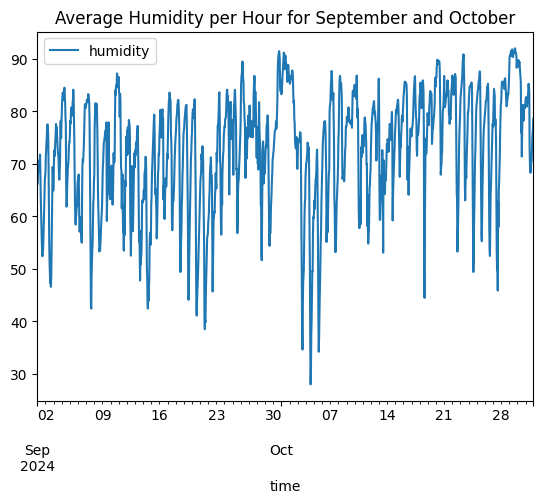

In [281]:
# Filter data for September and October
bme680_sept_oct = bme680_per_hour[(bme680_per_hour.index.month == 9) | (bme680_per_hour.index.month == 10)]

# Plot the filtered data
bme680_sept_oct.plot(y='humidity', kind='line', title='Average Humidity per Hour for September and October')
plt.show()

### Explore correlation between daily humidity shift

In [283]:
# Group by hour of the day and sum the number of worms detected
bme680_sept_oct.loc[:, 'hour'] = bme680_sept_oct.index.hour
mean_humidity_per_hour = bme680_sept_oct.groupby('hour')['humidity'].mean().reset_index()

mean_humidity_per_hour.head()

,hour,humidity
0,0,75.420922
1,1,76.545829
2,2,77.249731
3,3,77.987340
4,4,78.457787


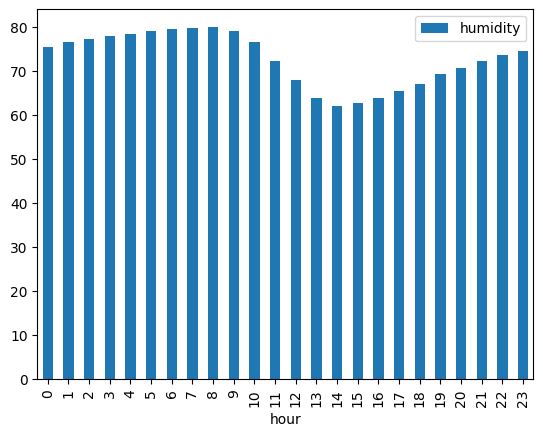

In [287]:
mean_humidity_per_hour.plot(x='hour', kind='bar')
plt.show()

In [297]:
merged_hourly_data = pd.merge(mean_humidity_per_hour, total_count_per_hour, on='hour')
merged_hourly_data.head()

,hour,humidity,num_worms
0,0,75.420922,184
1,1,76.545829,231
2,2,77.249731,240
3,3,77.987340,179
4,4,78.457787,190


<Axes: >

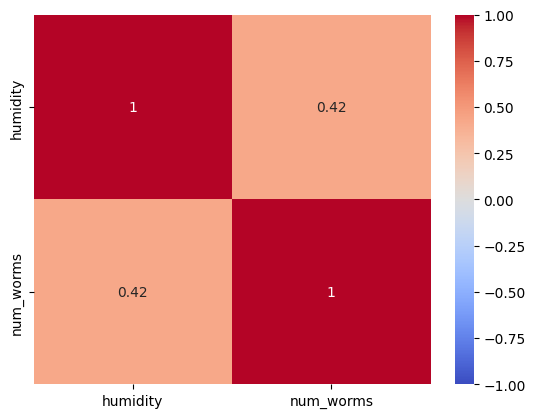

In [298]:
sns.heatmap(
    merged_hourly_data[['humidity', 'num_worms']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

#### Explore correlation between worm count and temperature, humidity, pressure

In [325]:
merged_data = pd.merge(bme680_per_hour, worms_per_hour, left_index=True, right_index=True)
merged_data.head()

,humidity,temperature,pressure,num_worms,hour
2024-08-26 00:00:00,67.234932,17.448359,1019.433892,0,0
2024-08-26 01:00:00,68.904603,17.193086,1019.385554,0,1
2024-08-26 02:00:00,71.370427,16.823750,1019.305363,0,2
2024-08-26 03:00:00,74.007851,16.594062,1019.199347,0,3
2024-08-26 04:00:00,75.013800,16.296602,1019.219298,0,4


<Axes: >

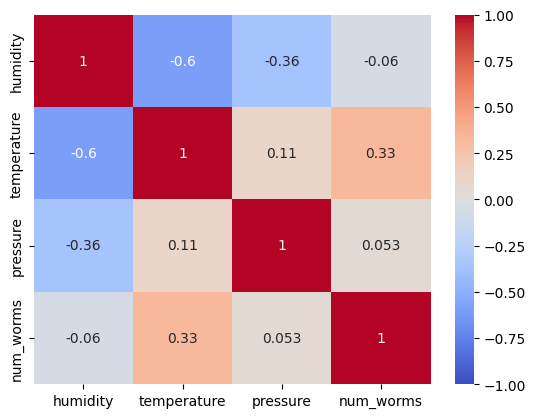

In [326]:
sns.heatmap(
    merged_data[['humidity', 'temperature', 'pressure', 'num_worms']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

<Axes: title={'center': 'Number of Worms Detected vs. Temperature'}, xlabel='temperature', ylabel='num_worms'>

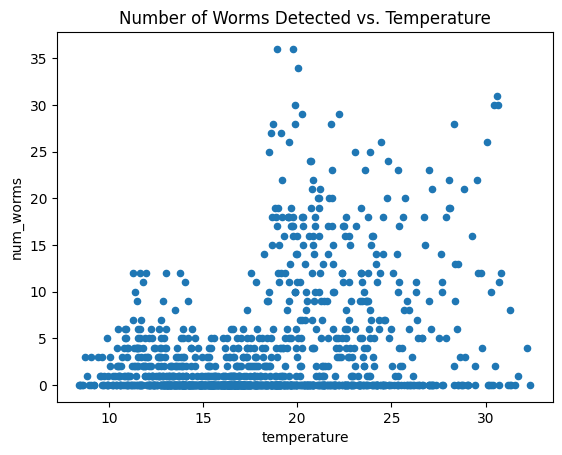

In [328]:
merged_data.plot(kind='scatter', x='temperature', y='num_worms', title='Number of Worms Detected vs. Temperature')

In [331]:
merged_data_by_day = merged_data.resample('D').agg({
    'humidity': 'mean',
    'temperature': 'mean',
    'pressure': 'mean',
    'num_worms': 'mean'
})

merged_data_by_day.head()

,humidity,temperature,pressure,num_worms
2024-08-26,67.917740,19.121528,1019.964386,0.000000
2024-08-27,59.886810,22.186657,1019.608628,0.125000
2024-08-28,53.139170,26.059696,1013.876607,0.000000
2024-08-29,63.597650,24.024767,1015.177012,1.916667
2024-08-30,54.239818,22.848278,1021.139572,11.375000


<Axes: >

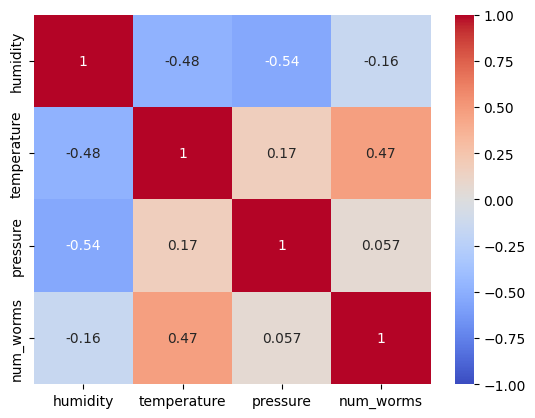

In [332]:
sns.heatmap(
    merged_data_by_day[['humidity', 'temperature', 'pressure', 'num_worms']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)